# Fetching Data

In [2]:
import pandas as pd
text = pd.read_csv('~/Downloads/abstract.csv')
text.info()
text.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


# Prob 1: 토픽모델링

## Prob 1-1
### Abstract를 사용하여 LDA 모델링을 하고 최적의 토픽 수를 결정하고 근거를 제시하세요.

n_components: 2, perplexity: 5244.609
n_components: 3, perplexity: 5265.323
n_components: 4, perplexity: 5353.862
n_components: 5, perplexity: 4887.700
n_components: 6, perplexity: 4810.054
n_components: 7, perplexity: 4910.722
n_components: 8, perplexity: 4966.731
n_components: 9, perplexity: 5091.932
n_components: 10, perplexity: 5191.345


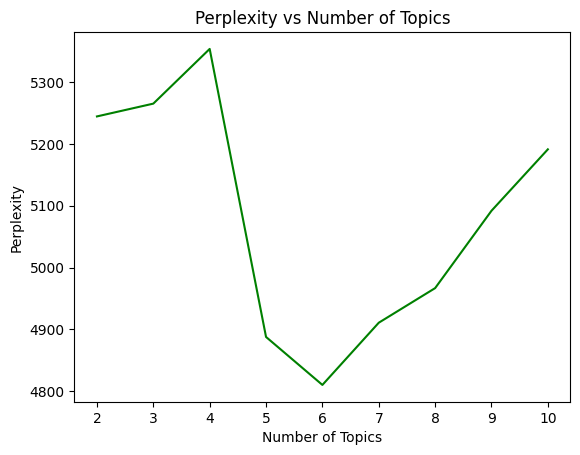

n_components with minimum perplexity: 6


In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# initialize countvectorizer and transform it
cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', min_df=5, max_df=0.5, ngram_range=(1, 2))
vectorizer = cv.fit_transform(text['ABSTRACT']) 

# perplexity function 
def show_perplexity(cv, start=8, end=30, max_iter=5, topic_word_prior=0.1, doc_topic_prior=1.0):
    iter_num = []
    per_value = []
    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components=i, max_iter=max_iter, topic_word_prior=topic_word_prior,
                                        doc_topic_prior=doc_topic_prior, learning_method='batch', n_jobs=-1, random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')
    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("Number of Topics")
    plt.ylabel("Perplexity")
    plt.title("Perplexity vs Number of Topics")
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:", show_perplexity(vectorizer, start=2, end=10))

The optimal number of topic number is 6 which has the lowest perplexity.

## Prob 1-2
### Prob 1-1의 결과에서 토픽별 Top-10 단어 및 그 분포를 나타내세요. (효과적인 시각화는 추가점수) 


In [8]:
# apply lda with 6 n_components based on previous result
lda = LatentDirichletAllocation(n_components = 6, 
max_iter=20,topic_word_prior= 0.1,doc_topic_prior=1.0,
learning_method='batch',n_jobs= -1,random_state=7)
review_topics = lda.fit_transform(vectorizer)


# print the top 10 words with the corresponding topic-word distribution
def print_top_words(model, feature_names, n_top_words,theta):
    data = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic # " + str(topic_idx+1) , end='\n')
        
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print(feature_names[i] + f'({topic[i]:.2f})', end=", ")
            data.append([feature_names[i], topic_idx, topic[i]])
        print('\n')
        
    # create a dataframe of words, theta, and topic number
    df = pd.DataFrame(data,columns=['word', 'topic', 'theta'])
    return df


df = print_top_words(lda, cv.get_feature_names_out(), 10, review_topics)

Topic # 1
problem(2077.00), time(1427.68), algorithm(1416.33), optimal(929.92), linear(884.86), problems(785.05), solution(742.42), function(742.08), number(725.56), paper(683.19), 

Topic # 2
based(1369.71), data(1345.65), paper(974.11), using(910.11), proposed(896.46), performance(853.94), approach(838.01), systems(773.14), time(708.64), used(602.86), 

Topic # 3
network(2253.35), learning(1885.19), networks(1794.58), neural(1405.27), deep(1171.28), model(846.85), information(761.71), neural networks(629.73), different(616.15), training(572.04), 

Topic # 4
data(2948.37), model(2452.90), models(1982.10), method(1586.94), methods(1399.32), based(1028.59), proposed(963.88), learning(953.75), approach(892.31), propose(841.66), 

Topic # 5
energy(1112.05), field(1026.80), model(994.37), phase(991.44), quantum(857.53), magnetic(790.10), spin(785.10), using(736.96), high(735.83), mass(653.10), 

Topic # 6
space(881.75), mathbb(869.10), prove(712.77), group(702.47), theory(628.57), finite(5

In [9]:
import altair as alt

alt.Chart(df).mark_bar().encode(
    x='word',
    y=alt.Y('theta', scale=alt.Scale(domain=[0, 3000])),
    tooltip=['theta']).properties(
    width=800, title='Bar Chart of Top 10 Words in Topic 1').transform_filter(
    (alt.datum.topic == 0)
)

alt.Chart(...)

This topic maybe related to computer science on optimization.

In [11]:
alt.Chart(df).mark_bar().encode(
    x='word',y=alt.Y('theta', scale=alt.Scale(domain=[0, 3000])),tooltip=['theta']).properties(
    width=800, title='Bar Chart of Top 10 Words in Topic 2').transform_filter(
    (alt.datum.topic == 1)
)

alt.Chart(...)

This topic is similar to topic 1 but more towards to data science.

In [13]:
alt.Chart(df).mark_bar().encode(
    x='word',y=alt.Y('theta', scale=alt.Scale(domain=[0, 3000])),tooltip=['theta']).properties(
    width=800, title='Bar Chart of Top 10 Words in Topic 3').transform_filter(
    (alt.datum.topic == 2)
)

alt.Chart(...)

This topic is closely related to neural network algorithms.

In [15]:
alt.Chart(df).mark_bar().encode(
    x='word',y=alt.Y('theta', scale=alt.Scale(domain=[0, 3000])),tooltip=['theta']).properties(
    width=800, title='Bar Chart of Top 10 Words in Topic 4').transform_filter(
    (alt.datum.topic == 3)
)

alt.Chart(...)

This topic is similar to topic 1 & 2 but more towards machine learning models.

In [17]:
alt.Chart(df).mark_bar().encode(
    x='word',y=alt.Y('theta', scale=alt.Scale(domain=[0, 3000])),tooltip=['theta']).properties(
    width=800, title='Bar Chart of Top 10 Words in Topic 5').transform_filter(
    (alt.datum.topic == 4)
)

alt.Chart(...)

This topic is clearly physics.

In [19]:
alt.Chart(df).mark_bar().encode(
    x='word',y=alt.Y('theta', scale=alt.Scale(domain=[0, 3000])),tooltip=['theta']).properties(
    width=800, title='Bar Chart of Top 10 Words in Topic 6').transform_filter(
    (alt.datum.topic == 5)
)

alt.Chart(...)

This topic is related to mathematics.

# Prob 2: 감성분석

In [22]:
text = pd.read_csv('~/Downloads/Twitter_Sentiment_Validation.csv',header=None)
text.columns = ["ID", "entity", "sentiment","content"] 

text.info()
text.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   content    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


,ID,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## Prob 1-3

### Neutral과 Irrelevant 데이터를 제외한 후, Lexicon-based Method 중 1개를 선택해 Validation 데이터에 적용시 Confusion Matrix를 보이고, Accuracy 및 F1-Score를 계산하세요.


In [24]:
# exclude neutral and irrelevant datasets
text = text[(text['sentiment'] != 'Neutral') & (text['sentiment'] != 'Irrelevant')]
text['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

text = text.dropna()
analyzer = SentimentIntensityAnalyzer()

# using apply function to use vader in predicting sentiment where compound score over 0 is positive and else is negative
text['predicted_sentiment'] = text['content'].apply(
    lambda x: 'Positive' if analyzer.polarity_scores(x)['compound'] >= 0 else 'Negative'
)

# evaluation
conf_matrix = confusion_matrix(text['sentiment'], text['predicted_sentiment'])
accuracy = accuracy_score(text['sentiment'], text['predicted_sentiment'])
f1 = f1_score(text['sentiment'], text['predicted_sentiment'], pos_label='Positive')

print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 score: {f1:.2f}")

Accuracy: 0.71
F-1 score: 0.74


<Axes: >

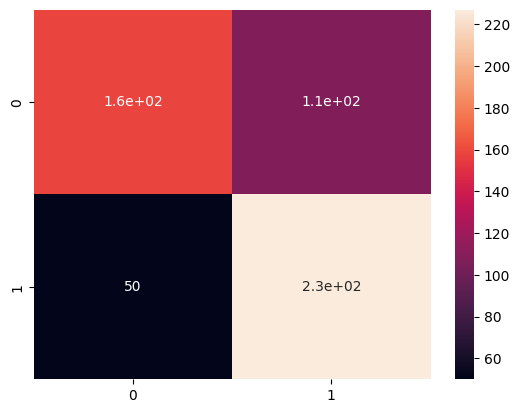

In [26]:
import seaborn as sns
sns.heatmap(conf_matrix,annot=True)

In [27]:
from sklearn.metrics import classification_report

report = classification_report(text['sentiment'], text['predicted_sentiment'])
print(report)

              precision    recall  f1-score   support

    Negative       0.76      0.59      0.67       266
    Positive       0.68      0.82      0.74       277

    accuracy                           0.71       543
   macro avg       0.72      0.71      0.70       543
weighted avg       0.72      0.71      0.71       543



The low recall score for negative articles mean the model only captures 59% of actual negative articles which is concerning.

## Prob 1-4: Prob 1-3처럼 정제된 데이터에 Machine Learning을 이용해 감성분석 모델을 Train 데이터로 훈련시킨 후, Validation 데이터로 성능을 검증하세요. (Confusion Matrix, Accuracy 및 F1-Score 계산)


In [30]:
text.head()

,ID,entity,sentiment,content,predicted_sentiment
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Positive
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,Positive
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",Positive


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.classifier import ConfusionMatrix

X_train,X_test,y_train,y_test = train_test_split(
    text['content'],text['sentiment'],test_size=0.2,random_state=42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

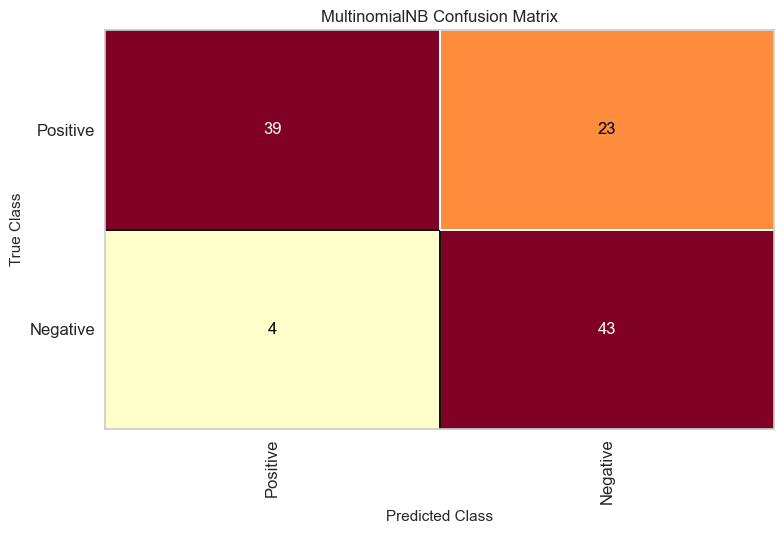

Accuracy: 0.75
F-1 score: 0.76
              precision    recall  f1-score   support

    Negative       0.91      0.63      0.74        62
    Positive       0.65      0.91      0.76        47

    accuracy                           0.75       109
   macro avg       0.78      0.77      0.75       109
weighted avg       0.80      0.75      0.75       109



In [32]:
from sklearn.naive_bayes import MultinomialNB 

# naive_bayes model
model = MultinomialNB() 
model.fit(X_train_tfidf,y_train)

y_pred = model.predict(X_test_tfidf)

# evaluation
cm_viz = ConfusionMatrix(model, classes=['Positive', 'Negative'])
cm_viz.fit(X_train_tfidf, y_train)
cm_viz.score(X_test_tfidf, y_test)
cm_viz.show()

accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,pos_label='Positive')
print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 score: {f1:.2f}")
report = classification_report(y_test,y_pred)
print(report)

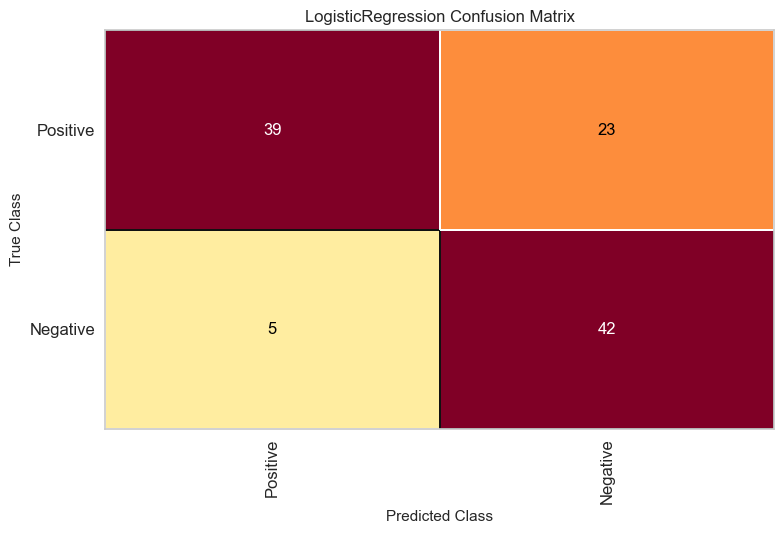

Accuracy: 0.74
F-1 score: 0.75
              precision    recall  f1-score   support

    Negative       0.89      0.63      0.74        62
    Positive       0.65      0.89      0.75        47

    accuracy                           0.74       109
   macro avg       0.77      0.76      0.74       109
weighted avg       0.78      0.74      0.74       109



In [33]:
from sklearn.linear_model import LogisticRegression

# logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf,y_train)

y_pred = model.predict(X_test_tfidf)

# evaluation
cm_viz = ConfusionMatrix(model, classes=['Positive', 'Negative'])
cm_viz.fit(X_train_tfidf, y_train)
cm_viz.score(X_test_tfidf, y_test)
cm_viz.show()

accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,pos_label='Positive')
print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 score: {f1:.2f}")
report = classification_report(y_test,y_pred)
print(report)

Machine learning method especially using logistic regression has a slightly higher accuracy and f1-score than lexicon-based method.

## Prob 1-5: Prob 1-4에 Neutral 데이터를 추가해서 ML모델을 만들고 성능을 분석하고, 또한 Prob 1-4의 성능과 비교하세요.


In [36]:
text = pd.read_csv('~/Downloads/Twitter_Sentiment_Validation.csv',header=None)
text.columns = ["ID", "entity", "sentiment","content"] 
text.info()
text.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   content    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


,ID,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [37]:
# only excluding irrelevant datasets
text = text.dropna()
text = text[text['sentiment'] != 'Irrelevant']
text['sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [38]:
X_train,X_test,y_train,y_test = train_test_split(
    text['content'],text['sentiment'],test_size=0.2,random_state=42)

# Term Frequency-Inverse Document Frequency
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

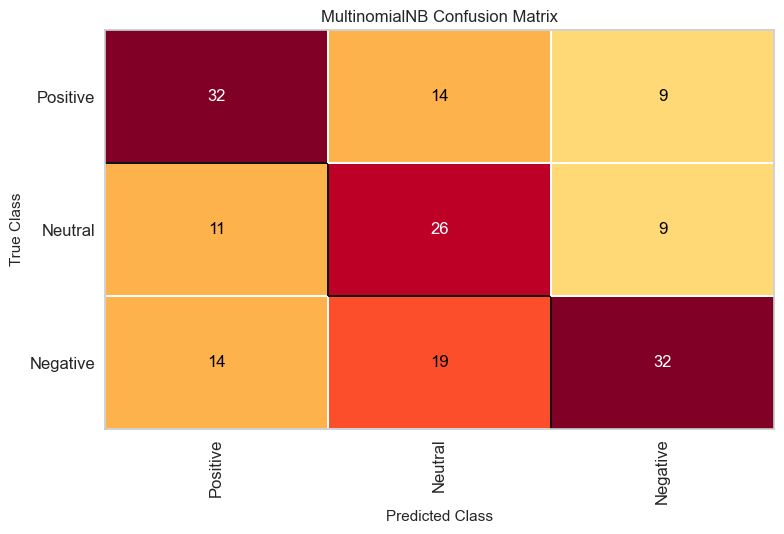

Accuracy: 0.54
F-1 score: 0.54
              precision    recall  f1-score   support

    Negative       0.56      0.58      0.57        55
     Neutral       0.44      0.57      0.50        46
    Positive       0.64      0.49      0.56        65

    accuracy                           0.54       166
   macro avg       0.55      0.55      0.54       166
weighted avg       0.56      0.54      0.54       166



In [39]:
# naive bayes training
model = MultinomialNB(alpha=0.01) 
model.fit(X_train_tfidf,y_train)

y_pred = model.predict(X_test_tfidf)

# evaluation
cm_viz = ConfusionMatrix(model, classes=['Positive', 'Neutral', 'Negative'])
cm_viz.fit(X_train_tfidf, y_train)
cm_viz.score(X_test_tfidf, y_test)
cm_viz.show()

accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 score: {f1:.2f}")
report = classification_report(y_test,y_pred)
print(report)

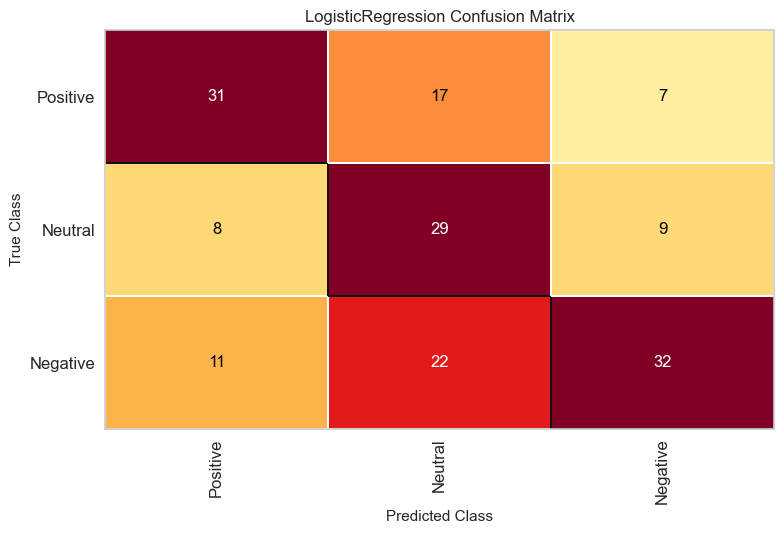

Accuracy: 0.55
F-1 score: 0.56
              precision    recall  f1-score   support

    Negative       0.62      0.56      0.59        55
     Neutral       0.43      0.63      0.51        46
    Positive       0.67      0.49      0.57        65

    accuracy                           0.55       166
   macro avg       0.57      0.56      0.56       166
weighted avg       0.58      0.55      0.56       166



In [40]:
# logistic regression train
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train_tfidf,y_train)

y_pred = model.predict(X_test_tfidf)

# evaluation
cm_viz = ConfusionMatrix(model, classes=['Positive', 'Neutral', 'Negative'])
cm_viz.fit(X_train_tfidf, y_train)
cm_viz.score(X_test_tfidf, y_test)
cm_viz.show()

accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 score: {f1:.2f}")
report = classification_report(y_test,y_pred)
print(report)

The low recall score for positive articles mean the model only captures 49% of actual positive articles which is concerning (high false negatives). Also, the low precision score for neutral articles shows the model classifying article as neutral only has 43% chance of actually getting correct (high false positives). Models excluding only irrelevant sentiment data have lower accuracy and f1-score by approximately 0.2 when compared to models excluding both irrelevant and neutral sentiment datasets. 